In [1]:
# https://github.com/GeospatialGeeks/Satellite-Image-Building-Segmentation
# mount drive, turn on GPU runtime
%load_ext autoreload
%autoreload 2
%matplotlib inline
import PIL, os, mimetypes
from fastai.vision import *
from fastai.utils.collect_env import *
Path.ls = lambda x: list(x.iterdir())
show_install(True)



```text
=== Software === 
python       : 3.6.9
fastai       : 1.0.61
fastprogress : 0.2.3
torch        : 1.5.1+cu101
torch cuda   : 10.1 / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro       : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env    : Unknown
python       : /usr/bin/python3
sys.path     : 
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utility to get the additional information


In [3]:
imgsdir = Path('/content/fastai/segbldg/data/images')
imgsname = get_image_files(imgsdir)
lblsdir = Path('/content/fastai/segbldg/data/labels')
lblsname = get_image_files(imgsdir)
get_y_fn = lambda x:lbls dir/f'{x.stem}{x.suffix}'


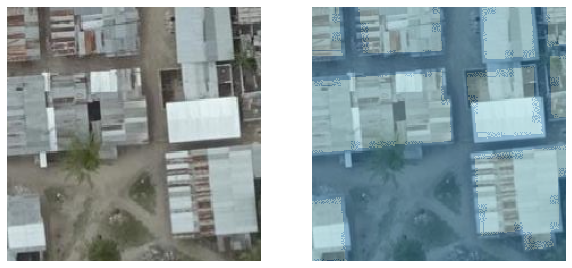

In [15]:
testindex = 2
imgtest = open_image(imgsname[testindex])
lbltest = open_mask(get_y_fn(imgsname[testindex]), div=True)
fig,ax = plt.subplots(1,2, figsize=(10,10))
imgtest.show(ax=ax[0], alpha=0.2)
imgtest.show(ax=ax[1], y=lbltest, cmap='binary', alpha=0.4)

In [28]:
IMGSHAPE = np.array(lbltest.shape[1:])
BS = 8

class lbllist(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)
    
class imglist(ImageImageList):
    _label_cls = lbllist

tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.2)    

data = (imglist.from_folder(imgsdir)
      .random_split_by_pct()
      .label_from_func(get_y_fn, classes=['0', '1'])
      .transform(tfms, size=IMGSHAPE, tfm_y=True)
      .databunch(bs=BS)
      .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


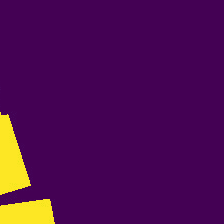

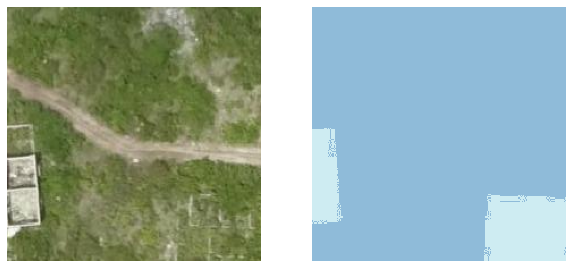

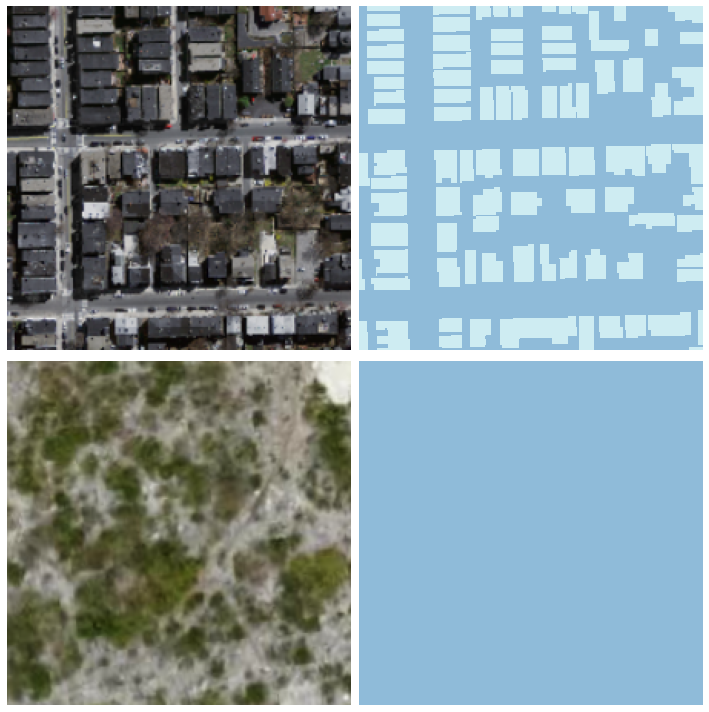

In [41]:
_,ax = plt.subplots(1,2,figsize=(10,10))
data.valid_ds.x[2].show(ax=ax[0])
data.valid_ds.y[2].show(ax=ax[1])
data.show_batch(2, figsize=(10,10))
data.train_ds.y[2].data
data.train_ds.y[2]

In [43]:
def dice_loss(h, y):
    smooth = 1.
    hflat = h[:,1,None].sigmoid().contiguous().view(-1).float()
    yflat = y.view(-1).float()
    union = (hflat * yflat).sum()
    return 1-( (2.*union+smooth)/((hflat+yflat).sum()+smooth) )

def combo_loss(h, y):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(h,y) + dice_loss(h,y)

# combo_loss(data.train_ds.y[2], data.train_ds.y[2])

In [44]:
def acc_fixed(h,y):
    y=y.squeeze(1).view(y.shape[0],-1)
    h=h.argmax(dim=1).view(y.shape[0],-1)
    return (y==h).float().mean()

def acc_thresh(h,y,thresh=0.5, sigmoid=True):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-44-1033f8e5f6cb>, line 6)